In [6]:
# Import modules

from music21 import *
import matplotlib.pyplot as plt
import pickle
import dimod.generators
import networkx as nx
import pandas as pd
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.samplers import SteepestDescentSolver
import dimod

from calculators import *
from boundaryDetection import *
from graphUtilities import *

In [2]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = corpus.parse("beethoven/opus74.mxl")
excerpt = beethoven
identifier = "opus74"

#excerpt.show("text")

In [11]:
# Boundary detection

phraseStack = {}
threshold = 0.15
weightings = [0.3, 0.6]

for part in excerpt.parts:
    phrases = extractPhrases(part, threshold, weightings, f"{part.id}")
    print(type(phrases))
    phraseStack.update(phrases)

print(phraseStack)

<class 'list'>


ValueError: dictionary update sequence element #0 has length 476; 2 is required

1933


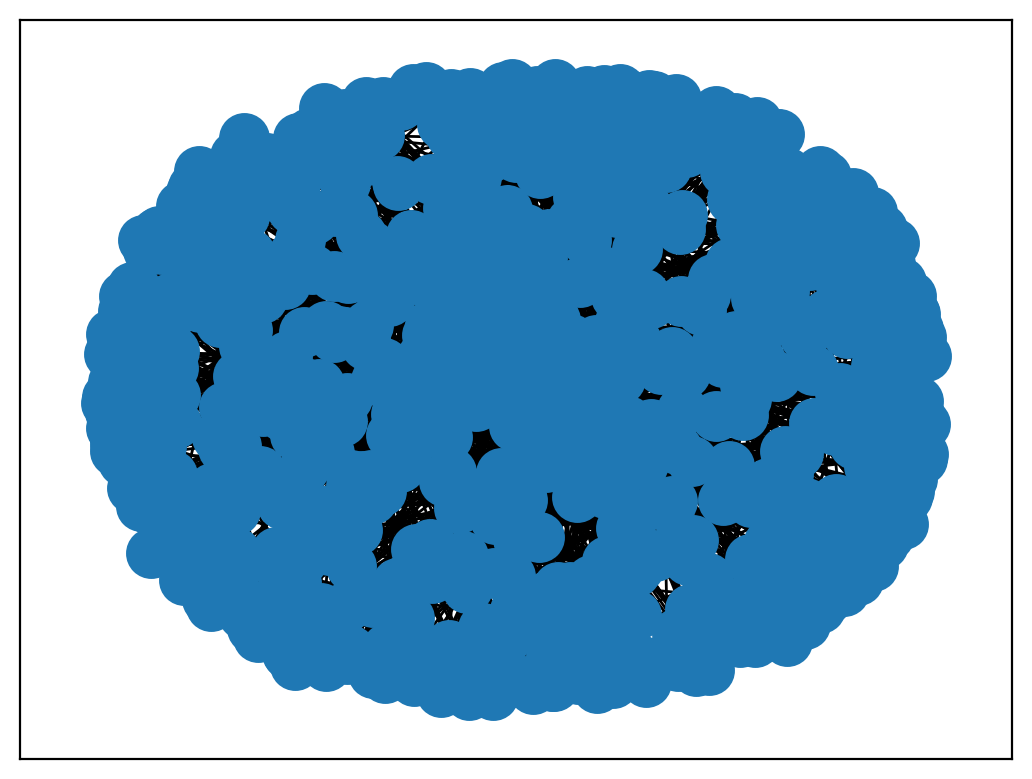

In [4]:
# Create graph
# Introduce multiprocessing
# Don't make graph from actual objects, make graph from strings and use dictionary to map (takes up too much RAM)

flatStack = [phrase for phrases in phraseStack for phrase in phrases]
uniquePairs = [(i, j) for i in range(len(flatStack)) for j in range(i+1, len(flatStack))]

#print(len(flatStack))
#for p in flatStack: print(p.id, p.entropy)
#for i, j in uniquePairs: print(flatStack[i].id, flatStack[j].id, hasOverlap(flatStack[i], flatStack[j]))

edges = []

for i, j in uniquePairs:
    if hasOverlap(flatStack[i], flatStack[j]):
        edges.append((flatStack[i], flatStack[j]))


SimpleG = nx.Graph()
ObjectG = nx.Graph()

ObjectG.add_nodes_from(flatStack)
ObjectG.add_edges_from(edges)

"""
for p in flatStack:
    SimpleG.add_node(p.id)
    ObjectG.add_node(p)

    for n in ObjectG.nodes:
        if p != n and hasOverlap(p, n):
            SimpleG.add_edge(p.id, n.id)
            ObjectG.add_edge(p, n)

#G = defineGraph(edges)
"""

1933


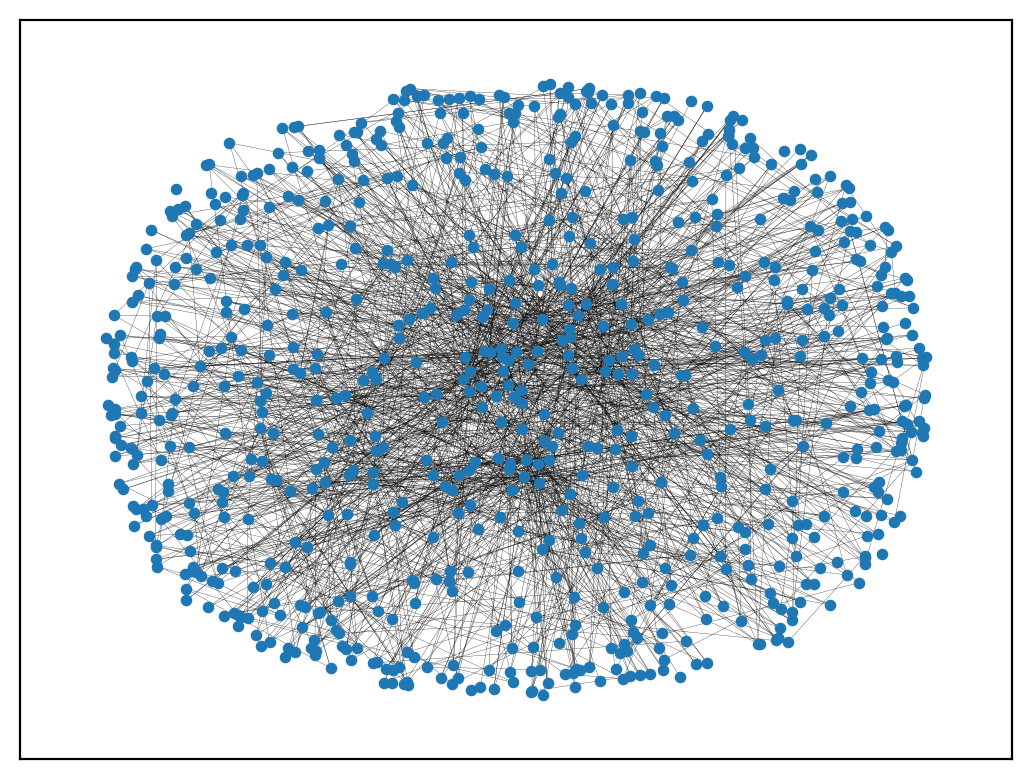

In [8]:
pos = nx.spring_layout(ObjectG, k=0.5) # Force specific layout
nx.draw_networkx(ObjectG, pos=pos, with_labels=False, node_size=10, width=0.1)

print(len(edges))

In [5]:
pickle.dump(ObjectG, open(f"../Pickles/BIG_opus74_objectGraph.pkl", "wb"))

In [ ]:
phraseEntropies = [(phrase.id, phrase.entropy + 1) for phrase in flatStack]
bqm = dimod.generators.maximum_weight_independent_set(SimpleG.edges, phraseEntropies, strength_multiplier=2)
print(bqm)

In [ ]:
# Solve on QPU

def solveWeightedMIS(G: nx.Graph, weights: list[tuple] = [], sampler=EmbeddingComposite(DWaveSampler()), num_reads: int = 100, strength_multiplier: float = 2) -> pd.DataFrame:
    bqm = dimod.generators.maximum_weight_independent_set(G.edges, weights, strength_multiplier=strength_multiplier)
    sampler = sampler
    sampleset = sampler.sample(bqm, num_reads = num_reads)
    return sampleset.to_pandas_dataframe(True)

df = solveWeightedMIS(SimpleG, phraseEntropies, num_reads=1000)

In [ ]:
# Show results

print(df.head())
#print(df["energy"].sort_values(ascending=True))

sample = df["sample"][0]
chosen = [x for x in sample if sample[x] == 1]

print(chosen)
print(len(chosen))

nx.draw_networkx(SimpleG, pos=pos, nodelist=chosen)

In [ ]:
# Final arrangement

arrangement = stream.Stream()

for phrase in flatStack:
    if phrase.id in chosen:
        arrangement.mergeElements(phrase)

arrangement.show()


In [38]:
# Save data

excerpt.write("xml", f"../Pickles/{identifier}_excerpt.xml")
pickle.dump(phraseStack, open(f"../Pickles/{identifier}_phraseStack.pkl", "wb"))
pickle.dump(SimpleG, open(f"../Pickles/{identifier}_simpleGraph.pkl", "wb"))
pickle.dump(ObjectG, open(f"../Pickles/{identifier}_objectGraph.pkl", "wb"))
pickle.dump(df, open(f"../Pickles/{identifier}_df.pkl", "wb"))